In [3]:
%load_ext autoreload
%autoreload 2

%config IPCompleter.greedy=True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy import units

import importlib

import snapshot_obj
import trace_halo
import dataset_compute
import subhalo

In [5]:
importlib.reload(snapshot_obj)
importlib.reload(trace_halo)
importlib.reload(dataset_compute)
importlib.reload(subhalo)

<module 'subhalo' from '/home/kasper/Curvaton_Simulations/APOSTLE_analysis/subhalo.py'>

# Plotting trajectories of halos

## Tracing a satellite

In [107]:
sim_id = "CDM_V1_LR"
start = 127; stop = 105
gn=1
snap0 = snapshot_obj.Snapshot(sim_id, start)
central = subhalo.Subhalo(sim_id, start, gn, 0)

First, identify the central halo through snapshots:

In [108]:
tracer = central.trace(stop=stop)
print(tracer)

{127: (1, 0), 126: (1.0, 0.0), 125: (1.0, 0.0), 124: (1.0, 0.0), 123: (1.0, 0.0), 122: (1.0, 0.0), 121: (1.0, 0.0), 120: (1.0, 0.0), 119: (1.0, 0.0), 118: (1.0, 0.0), 117: (1.0, 0.0), 116: (1.0, 0.0), 115: (1.0, 0.0), 114: (1.0, 0.0), 113: (1.0, 0.0), 112: (1.0, 0.0), 111: (1.0, 0.0), 110: (1.0, 0.0), 109: (1.0, 0.0), 108: (1.0, 0.0), 107: (1.0, 0.0), 106: (1.0, 0.0), 105: (1.0, 0.0)}


Then, select a satellite that can be traced back through a couple snapshots (for instance, the M31 satellite (1,4)):

In [109]:
sgn=4
satellite = subhalo.Subhalo(sim_id, start, gn, sgn)
sat_tracer = satellite.trace(stop=stop)
print(sat_tracer)

{127: (1, 4), 126: (1.0, 3.0), 125: (1.0, 3.0), 124: (1.0, 2.0), 123: (1.0, 2.0), 122: (1.0, 2.0), 121: (1.0, 2.0), 120: (1.0, 2.0), 119: (1.0, 3.0), 118: (1.0, 3.0), 117: (1.0, 3.0), 116: (1.0, 3.0), 115: (1.0, 2.0), 114: (1.0, 1.0), 113: (1.0, 2.0), 112: (1.0, 2.0), 111: (1.0, 2.0), 110: (1.0, 2.0), 109: (1.0, 2.0), 108: (1.0, 2.0)}


Compute the distance from the central halo for each snapshot:

In [110]:
snap_ids = list(sat_tracer.keys())
snap_ids = np.sort(snap_ids)
d = [satellite.distance_to_central(sid) for sid in list(snap_ids)]

In [111]:
d = np.array(d).reshape((len(d),3)) * units.cm.to(units.kpc)

Plot in the xy- and xz-plane:

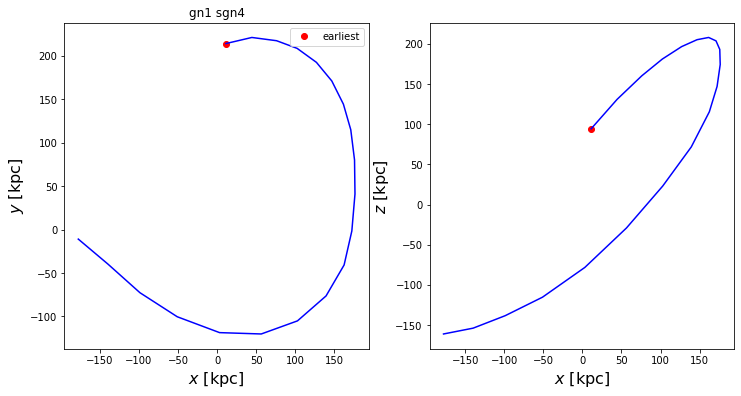

In [112]:
fig,ax = plt.subplots(ncols=2, figsize=(12,6))

ax[0].set_title('gn{} sgn{}'.format(gn,sgn))

ax[0].plot(d[-1,0], d[-1,1], 'ro', label='earliest')
ax[0].plot(d[:,0], d[:,1], 'b')
ax[0].set_xlabel('$x$ [kpc]', fontsize=16)
ax[0].set_ylabel('$y$ [kpc]', fontsize=16)

ax[1].plot(d[-1,0], d[-1,2], 'ro')
ax[1].plot(d[:,0], d[:,2], 'b')
ax[1].set_xlabel('$x$ [kpc]', fontsize=16)
ax[1].set_ylabel('$z$ [kpc]', fontsize=16)

ax[0].legend()

# Save figure:

filename = 'satellite_trajectory_gn{}sgn{}.png'.format(gn,sgn)

home = os.path.dirname(snapshot_obj.__file__)
path = os.path.join(home,"Figures")

# If the directory does not exist, create it
if not os.path.exists(path):
    os.makedirs(path)
plt.savefig(os.path.join(path,filename), dpi=200)

# Plot evolution of mass components

In [113]:
z = np.zeros(snap_ids.size)
for i,sid in enumerate(snap_ids):
    z[i] = snapshot_obj.Snapshot(sim_id, sid).get_redshift()

In [114]:
masses = np.zeros((snap_ids.size, 6))
for i,sid in enumerate(snap_ids):
    masses[i] = satellite.get_halo_data("MassType", sid) * units.g.to(units.Msun)

/home/kasper/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  from ipykernel import kernelapp as app


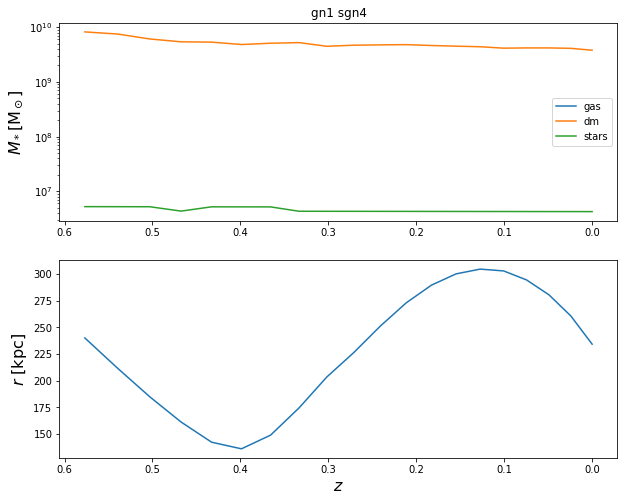

In [115]:
fig,ax = plt.subplots(nrows=2, figsize=(10,8))

ax[0].set_title('gn{} sgn{}'.format(gn,sgn))

ax[0].set_yscale('log')
ax[0].set_ylabel('$M_*[\mathrm{M_\odot}]$', fontsize=16)

ax[1].set_xlabel('$z$', fontsize=16)
ax[1].set_ylabel('$r$ [kpc]', fontsize=16)

ax[0].invert_xaxis()
ax[1].invert_xaxis()

for pt,l in zip([0,1,4],['gas', 'dm', 'stars']):
    ax[0].plot(z, masses[:,pt], label=l)
    
ax[0].legend()

ax[1].plot(z, np.linalg.norm(d, axis=1))

# Save figure:

filename = 'satellite_mass_evol_gn{}sgn{}.png'.format(gn,sgn)

home = os.path.dirname(snapshot_obj.__file__)
path = os.path.join(home,"Figures")

# If the directory does not exist, create it
if not os.path.exists(path):
    os.makedirs(path)
plt.savefig(os.path.join(path,filename), dpi=200)